In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [38]:
# dataset parameters

size = (64, 64, 3)
samples = 100_000 #_000
max_count = 2

size_max=24
size_min=22

thickness = 3

sq_ch = 0
circ_ch = 2

dataset_tensor = np.ones((samples, *size), np.float32)
labels_tensor = np.zeros((samples, 2), np.float32)
print(dataset_tensor.shape)
print(labels_tensor.shape)

(100000, 64, 64, 3)
(100000, 2)


In [39]:
def draw_sq(arr, l, c, ch=0):
    top_left = (c[0] - l // 2, c[1] - l // 2)
    arr[top_left[0]:top_left[0] + l, top_left[1], ch] -= 1
    arr[top_left[0], top_left[1]:top_left[1] + l, ch] -= 1
    arr[top_left[0] + l, top_left[1]:top_left[1] + l + 1, ch] -= 1
    arr[top_left[0]:top_left[0] + l, top_left[1] + l, ch] -= 1
    return arr
    
def draw_circ(arr, r, c, ch=1):
    for angle in np.arange(0, 2 * np.pi, 1/2/r):
        x = int(c[0] - 1 + r * np.cos(angle))
        y = int(c[1] - 1 + r * np.sin(angle))
        arr[x, y, ch] -= 1
    return arr

def draw_thick_sq(arr, l, c, ch=0, thickness=4):
    im = np.copy(arr)
    for i in range(thickness):
        im = draw_sq(im, l - i, c, ch)
    im = np.maximum(im, arr - 1)
    return im
        
def draw_thick_circ(arr, r, c, ch=0, thickness=4):
    im = np.copy(arr)
    for i in range(thickness):
        im = draw_circ(im, r - i, c, ch)
    im = np.maximum(im, arr - 1)
    return im
        

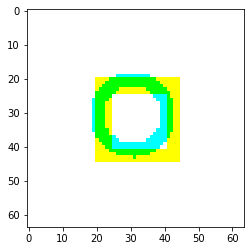

In [40]:
im = np.ones((64, 64, 3), np.float32)

im = draw_thick_circ(im, 12, (32, 32), 0)

im = draw_thick_sq(im, 24, (32, 32), 2, 8)

plt.imshow(im)

[0. 1.]


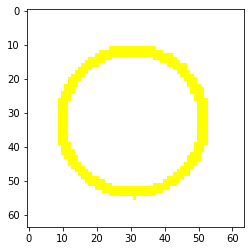

In [41]:
for i in range(samples):
    print(i, end='\r')
    overlap = -1
    
    while overlap != 2:
        n_circ, n_sq = np.random.choice(np.arange(0, max_count + 1), 2)
        
        A_candidate = np.ones(size, np.float32)
        sz_circ, sz_sq = np.random.choice(np.arange(size_min, size_max), n_circ), np.random.choice(np.arange(size_min, size_max), n_sq)
        sq_c_0, sq_c_1 = np.random.choice(np.arange((size_max // 2) + 2, size[0] - (size_max // 2) - 2), n_sq), np.random.choice(np.arange((size_max // 2) + 2, size[1] - (size_max // 2) - 1), n_sq)
        circ_c_0, circ_c_1 = np.random.choice(np.arange((size_max) + 2, size[0] - (size_max) - 2), n_circ), np.random.choice(np.arange((size_max) + 2, size[1] - (size_max) - 1), n_circ)

        for j, c in enumerate(zip([z for z in sq_c_0], [z for z in sq_c_1])):
            # draw square of size at position
            A_candidate = draw_thick_sq(A_candidate, sz_sq[j], c, sq_ch, thickness)
        
        for j, c in enumerate(zip([z for z in circ_c_0], [z for z in circ_c_1])):
            # draw circle at position
            A_candidate = draw_thick_circ(A_candidate, sz_circ[j], c, circ_ch, thickness)
        
        overlap = np.min(np.sum(A_candidate, -1))
    
    dataset_tensor[i] = A_candidate
    # circle fraction over square fraction is the label
    squares = np.sum(np.ones(size[:-1]) - A_candidate[:, :, sq_ch]) / (np.sum(np.ones(size[:-1]) - A_candidate[:, :, circ_ch]) + np.sum(np.ones(size[:-1]) - A_candidate[:, :, sq_ch]))
    labels_tensor[i] = [squares, 1 - squares]

dataset_tensor.shape
plt.imshow(dataset_tensor[0])
print(labels_tensor[0])

In [42]:
print(np.max(labels_tensor))
print(np.mean(labels_tensor, axis=0))

1.0
[0.5511741  0.44882652]


In [43]:
with open('./data/square_circles_20k.npy', 'wb') as fp:
    np.save(fp, dataset_tensor)
with open('./data/square_circles_20k_labels.npy', 'wb') as fp:
    np.save(fp, labels_tensor)

In [ ]:
from supervised.util import Config, Experiment, load_most_recent_results

from supervised.models.cnn import build_camnet_reorderedv4, build_camnet_reorderedv5, build_camnet_reorderedv7

from supervised.datasets.image_classification import deep_weeds, cats_dogs, dot_dataset, citrus_leaves, circles_squares
from supervised.data_augmentation.msda import mixup_dset, blended_dset
from supervised.data_augmentation.ssda import add_gaussian_noise_dset, custom_rand_augment_dset, foff_dset

import os
from os import listdir
from os.path import isfile, join

import pickle

"""
hardware_params must include:

    'n_gpu': uint
    'n_cpu': uint
    'node': str
    'partition': str
    'time': str (we will just write this to the file)
    'memory': uint
    'distributed': bool
"""
hardware_params = {
    'name': 'G4',
    'n_gpu': 1,
    'n_cpu': 32,
    'partition': 'ai2es',
    'nodelist': ['c733'],
    'time': '48:00:00',
    'memory': 8196,
    # The %04a is translated into a 4-digit number that encodes the SLURM_ARRAY_TASK_ID
    'stdout_path': '/scratch/jroth/supercomputer/text_outputs/exp%01a_stdout_%A.txt',
    'stderr_path': '/scratch/jroth/supercomputer/text_outputs/exp%01a_stderr_%A.txt',
    'email': 'jay.c.rothenberger@ou.edu',
    'dir': '/scratch/jroth/AI2ES-DL/',
    'array': '[0-8%1]',
    'results_dir': 'random'
}
"""
network_params must include:
    
    'network_fn': network building function
    'network_args': arguments to pass to network building function
        network_args must include:
            'lrate': float
    'hyperband': bool
"""
image_size = (64, 64, 3)


network_params = {
    'network_fn': build_camnet_reorderedv7,
    'network_args': {
        'lrate': 1e-3,
        'n_classes': 2,
        'iterations': 3,
        'conv_filters': 4,
        'conv_size': '[3]',
        'dense_layers': '[32, 16]',
        'learning_rate': 1e-3,
        'image_size': image_size,
        'l1': None,
        'l2': None,
        'alpha': 0,
        'beta': 2**(-10),
        'noise_level': 0.005,
        'depth': 4,
    },
    'hyperband': False
}
"""
experiment_params must include:
    
    'seed': random seed for computation
    'steps_per_epoch': uint
    'validation_steps': uint
    'patience': uint
    'min_delta': float
    'epochs': uint
    'nogo': bool
"""
experiment_params = {
    'seed': 42,
    'steps_per_epoch': 512,
    'validation_steps': 256,
    'patience': 10,
    'min_delta': 0.0,
    'epochs': 512,
    'nogo': False,
}
"""
dataset_params must include:
    'dset_fn': dataset loading function
    'dset_args': arguments for dataset loading function
    'cache': str or bool
    'batch': uint
    'prefetch': uint
    'shuffle': bool
    'augs': iterable of data augmentation functions
"""
dataset_params = {
    'dset_fn': circles_squares,
    'dset_args': {
        'image_size': image_size[:-1],
        'path': '../data/',
    },
    'cache': False,
    'cache_to_lscratch': False,
    'batch': 64,
    'prefetch': 8,
    'shuffle': True,
    'augs': []
}

config2 = Config(hardware_params, network_params, dataset_params, experiment_params)

exp2 = Experiment(config2)

print(exp2.params)
exp2.run_array(0)

{'seed': 42, 'steps_per_epoch': 512, 'validation_steps': 256, 'patience': 10, 'min_delta': 0.0, 'epochs': 512, 'nogo': False}
Size of Hyperparameter Grid: 1
{
	name: G4
	n_gpu: 1
	n_cpu: 32
	partition: ai2es
	nodelist: ['c733']
	time: 48:00:00
	memory: 8196
	stdout_path: /scratch/jroth/supercomputer/text_outputs/exp%01a_stdout_%A.txt
	stderr_path: /scratch/jroth/supercomputer/text_outputs/exp%01a_stderr_%A.txt
	email: jay.c.rothenberger@ou.edu
	dir: /scratch/jroth/AI2ES-DL/
	array: [0-8%1]
	results_dir: random
	}
{
	seed: 42
	steps_per_epoch: 512
	validation_steps: 256
	patience: 10
	min_delta: 0.0
	epochs: 512
	nogo: False
	}
{
	network_fn: <function build_camnet_reorderedv7 at 0x2b2f99fc4d30>
	network_args: {
		hyperband: False
		image_size: (64, 64, 3)
		l2: None
		learning_rate: 0.001
		iterations: 3
		l1: None
		noise_level: 0.005
		alpha: 0
		lrate: 0.001
		conv_size: [3]
		conv_filters: 4
		dense_layers: [32, 16]
		depth: 4
		beta: 0.0009765625
		n_classes: 2
		}
	hyperband: Fal

2023-01-16 11:02:20.109750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2023-01-16 11:02:20.550903: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-01-16 11:02:20.708973: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


512/512 [==============================] - 115s 164ms/step - loss: 0.0901 - clam_loss: 0.0895 - tf.math.multiply_4_loss: 7.4194 - clam_1_loss: 0.6215 - clam_categorical_accuracy: 0.9697 - clam_1_categorical_accuracy: 0.9725 - val_loss: 2.1523 - val_clam_loss: 2.1517 - val_tf.math.multiply_4_loss: 8.5349 - val_clam_1_loss: 0.6014 - val_clam_categorical_accuracy: 0.5473 - val_clam_1_categorical_accuracy: 0.5474 - lr: 0.0010
Epoch 2/512
512/512 [==============================] - 80s 156ms/step - loss: 0.0270 - clam_loss: 0.0264 - tf.math.multiply_4_loss: 6.6740 - clam_1_loss: 0.6132 - clam_categorical_accuracy: 0.9981 - clam_1_categorical_accuracy: 0.9929 - val_loss: 2.0604 - val_clam_loss: 2.0598 - val_tf.math.multiply_4_loss: 2.8520 - val_clam_1_loss: 0.6071 - val_clam_categorical_accuracy: 0.4501 - val_clam_1_categorical_accuracy: 0.9876 - lr: 7.1394e-04
Epoch 3/512
512/512 [==============================] - 80s 157ms/step - loss: 0.0215 - clam_loss: 0.0209 - tf.math.multiply_4_loss: 5


------------------------------------------------------------
Experimental Results Summary (Index: 0)
------------------------------------------------------------
Dataset Params: {
	dset_fn: <function circles_squares at 0x2ab3d9b84ca0>
	dset_args: {
		image_size: (64, 64)
		path: ../data/
		}
	cache: False
	cache_to_lscratch: False
	batch: 96
	prefetch: 8
	shuffle: True
	augs: [<function custom_rand_augment_dset at 0x2ab3d9b860e0>]
	}

Network Params:  {
	network_fn: <function build_camnet_reorderedv4 at 0x2ab3d8aec820>
	network_args: {
		hyperband: False
		image_size: (64, 64, 3)
		l2: None
		beta: 0.0009765625
		conv_filters: 32
		conv_size: [3]
		iterations: 3
		alpha: 0.0009765625
		depth: 3
		l1: None
		learning_rate: 0.0005
		noise_level: 0.005
		dense_layers: [32, 16]
		n_classes: 2
		lrate: 0.001
		}
	hyperband: False
	}
------------------------------------------------------------
Experiment Parameters: {
	seed: 42
	steps_per_epoch: 512
	validation_steps: 256
	patience: 10
	min

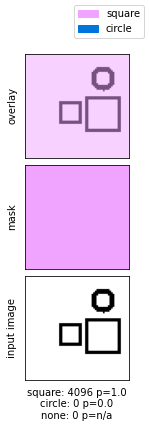

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


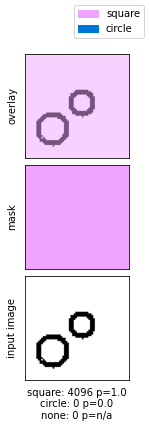

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


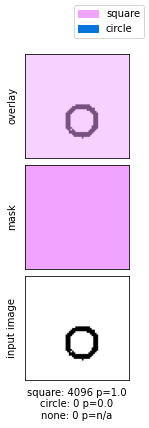

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


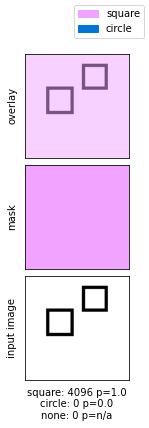

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


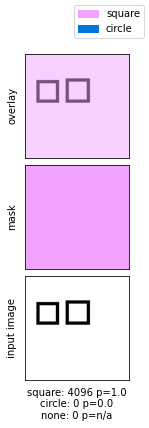

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


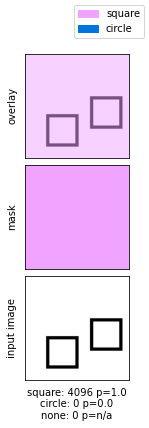

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


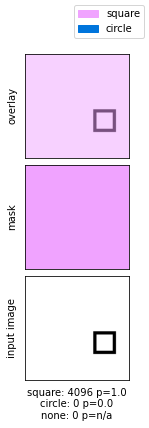

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


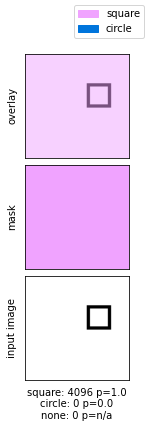

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


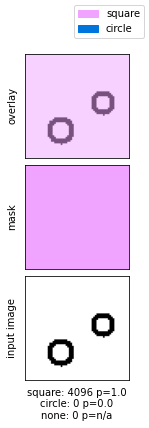

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


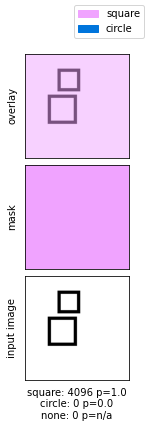

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


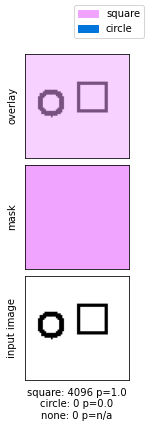

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


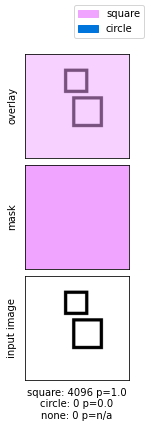

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


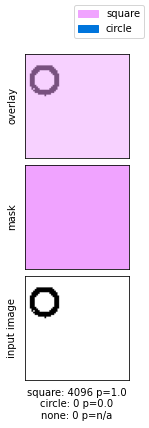

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


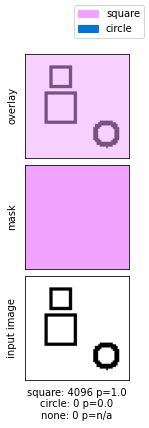

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


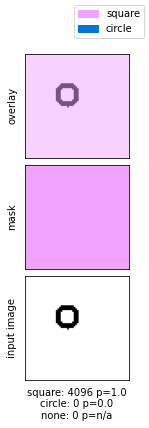

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


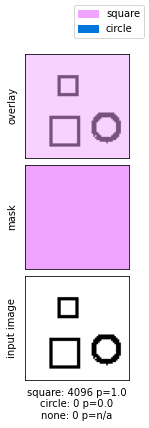

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


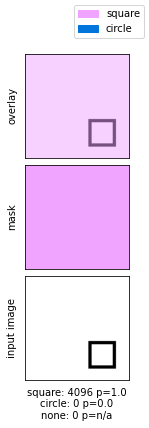

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


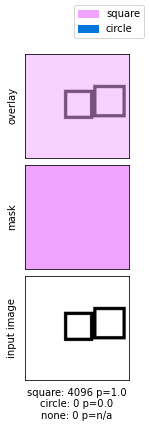

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


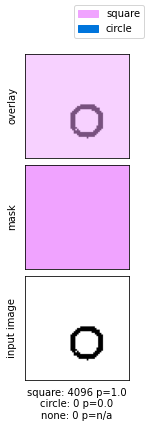

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


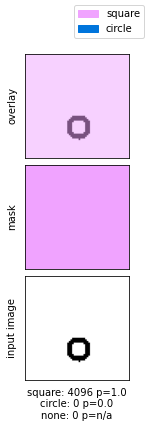

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


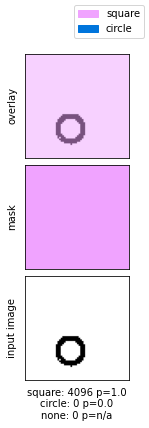

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


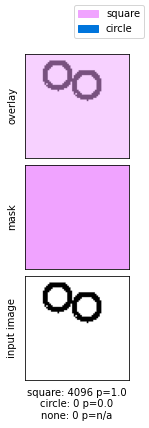

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


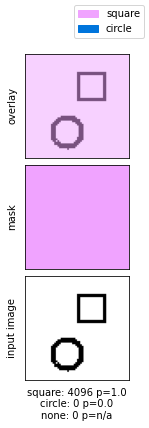

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


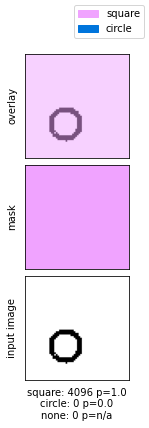

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


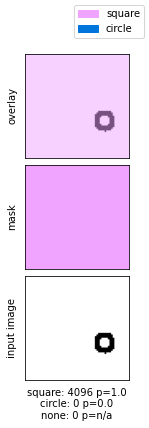

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


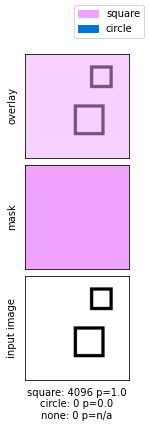

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


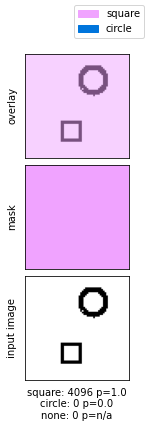

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


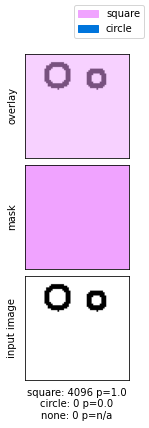

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


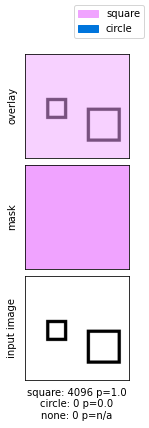

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


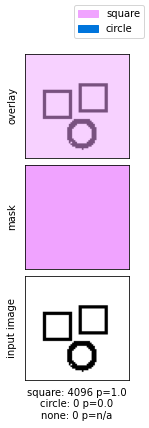

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


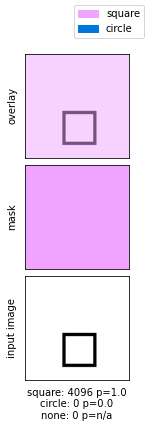

tf.Tensor([64 64  3], shape=(3,), dtype=int32) tf.Tensor([64 64  3], shape=(3,), dtype=int32)
(3, 1)


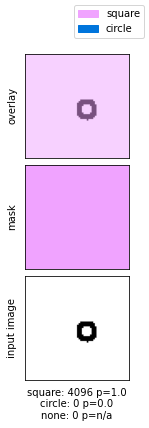

best_acc
(3, 1)


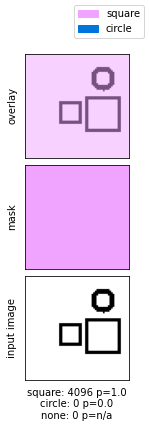

(3, 1)


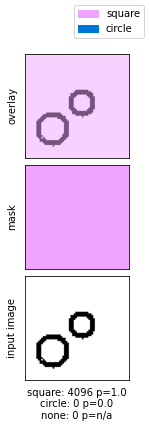

(3, 1)


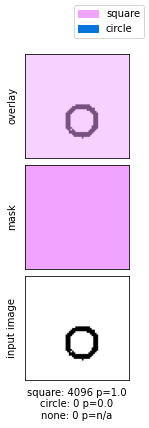

(3, 1)


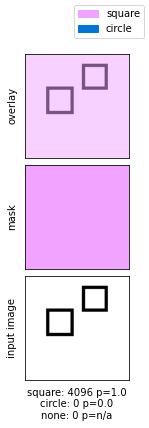

(3, 1)


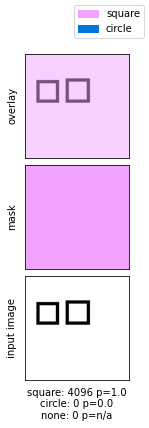

(3, 1)


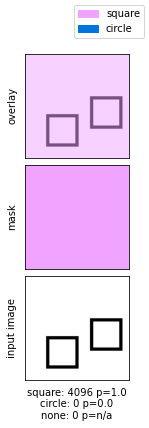

(3, 1)


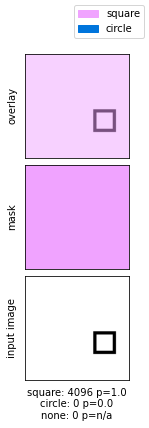

(3, 1)


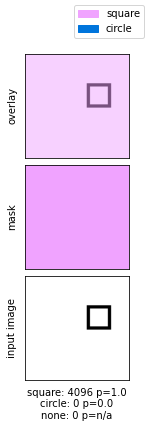

(3, 1)


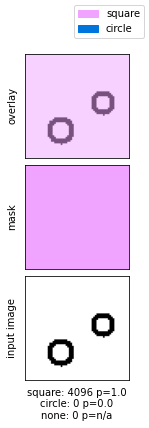

(3, 1)


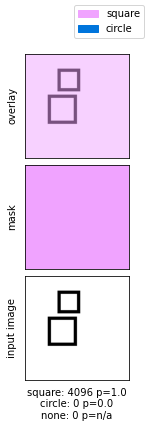

(3, 1)


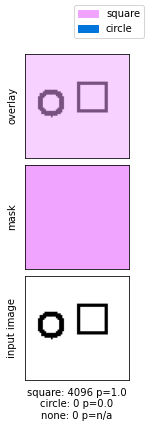

(3, 1)


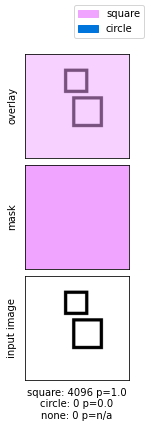

(3, 1)


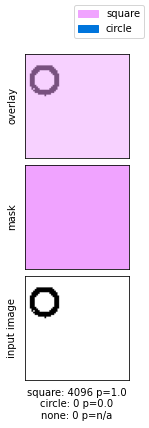

(3, 1)


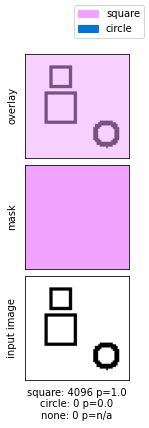

(3, 1)


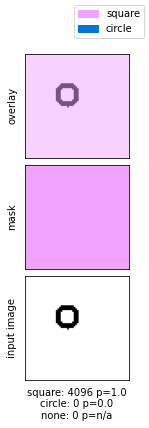

(3, 1)


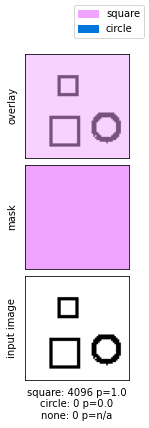

(3, 1)


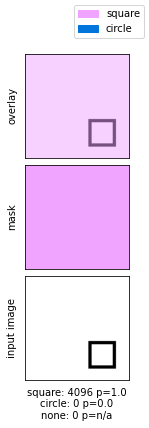

(3, 1)


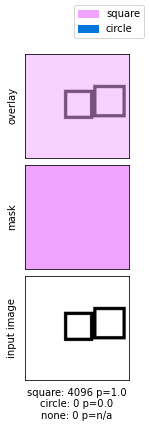

(3, 1)


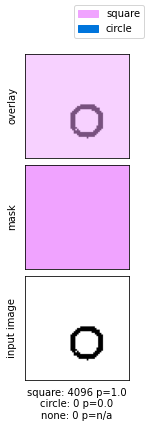

(3, 1)


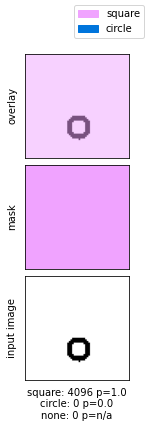

(3, 1)


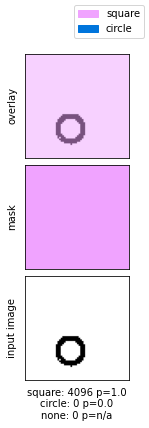

(3, 1)


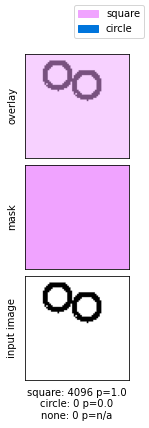

(3, 1)


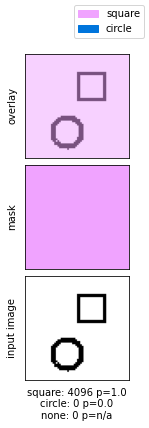

(3, 1)


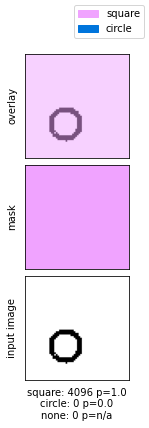

(3, 1)


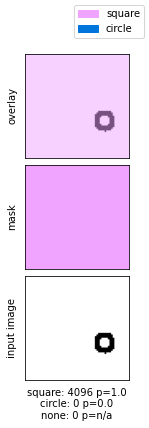

(3, 1)


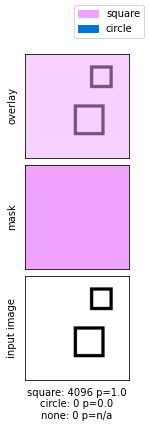

(3, 1)


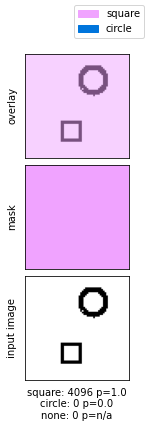

(3, 1)


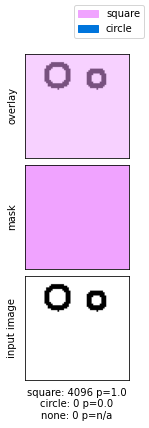

(3, 1)


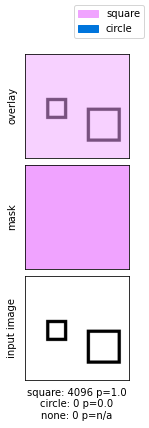

(3, 1)


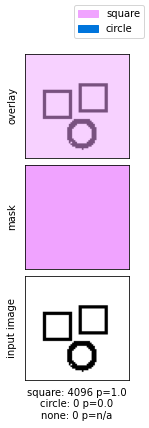

(3, 1)


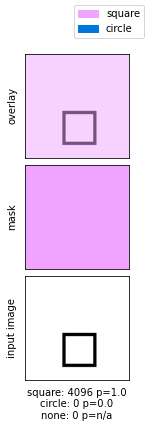

(3, 1)


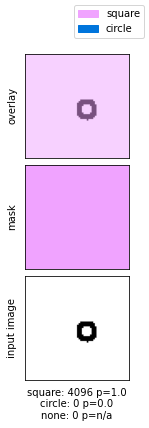

In [6]:
from supervised.models.cnn import *
from supervised.evaluations.image_classification import show_mask, masking_evaluation

from supervised.util import load_most_recent_results

result_path = '../random/'

results = load_most_recent_results(result_path, 1)[0]

results.summary()
results.config.dataset_params['dset_args']['path'] = '../data/'
class_names = results.config.dataset_params['dset_fn'](**results.config.dataset_params['dset_args'])['class_names']
model_data = results.model_data
keras_model = model_data.get_model()
test_dset = results.config.dataset_params['dset_fn'](**results.config.dataset_params['dset_args'])['train']
test_dset = test_dset.batch(results.config.dataset_params['batch'])

for x, y in iter(test_dset):
    print(x.shape, y.shape)
    break

#show_mask(test_dset, 16, model_data, class_names=class_names)
masking_evaluation(model_data, test_dset, class_names, 32)